In [1]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

import pickle
import gc 
import timeit
from ABC_algorithm import ABC

Populating the interactive namespace from numpy and matplotlib


In [2]:
######
# set up for the normal ABC example
######

prior_mean = -4.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

In [11]:
######
# set up for the g and k distribution
######

def SimulateGK(n, param):  #B>0, K>-1/2 #param is a vector of A, B, g, k
    A, B, g, k = param[0], param[1], param[2], param[3]
    u_values = np.random.uniform(low=0.0, high=1.0, size=n)
    x_values = np.zeros(n)
    for i in range(0,n):
        x_values[i] = A + B*(1+0.8*(1-np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) )) /(1 + np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) ))) *np.power((1+ np.power(sc.stats.norm.ppf(u_values[i], 0, 1),2)),k)*(sc.stats.norm.ppf(u_values[i], 0, 1))    
    return x_values

def GKPriorSampler(n):
    l = []
    for i in range(n):
        l.append(np.random.uniform(low=0.0, high=10.0, size=4)) # we assume uniform [1,10] prior for all 4 parameters
    return l

def GKLiklihoodSimulator(n, param):
    #unknown mean
    return SimulateGK(n, param)
    
def GKSummary(data):
    return np.sort(data)

data_gk = SimulateGK(25, [3, 1, 2, 0.5])

In [14]:
start_time = timeit.default_timer()
ABC(GKPriorSampler, GKLiklihoodSimulator, GKSummary, 0.01, data_gk , 1000)
print(timeit.default_timer() - start_time)

12.526547687004495


In [4]:
epsilon_seq = np.linspace(start=0, stop=10, num = 100)
n = 10000
k = 20
accepted_ratio = []
#Run abc with these epsilon and get the ratio of accepted samples
output_list = []

for eps in epsilon_seq:
    aux = 0
    for rep in range(k):
        ABC_run = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, eps, data , n)
        output_dict = {'eps': eps, 'accept ratio':sum(ABC_run.accept)/float(n)}
        output_list.append(output_dict)
        aux=aux+sum(ABC_run.accept)/n
    accepted_ratio.append(aux/k)
    
pickle.dump(output_list, open( "data/acceptance_rate_normal.p", "wb" ) )

NameError: name 'pickle' is not defined

[0.0, 0.010595000000000002, 0.021855, 0.032369999999999996, 0.043295, 0.05439500000000001, 0.06618500000000002, 0.07738500000000001, 0.08663499999999999, 0.09857, 0.111185, 0.12136, 0.13242, 0.14393000000000003, 0.15731500000000004, 0.16920999999999997, 0.18082, 0.19118000000000002, 0.20560500000000004, 0.21704500000000002, 0.22923500000000002, 0.2414600000000001, 0.25446, 0.26695, 0.28127499999999994, 0.292575, 0.306585, 0.32073, 0.33302, 0.34768499999999997, 0.361165, 0.372695, 0.3862650000000001, 0.400705, 0.41409, 0.4283600000000001, 0.441925, 0.4547499999999999, 0.46817000000000003, 0.48482000000000014, 0.4991999999999999, 0.5097250000000001, 0.5252899999999999, 0.53846, 0.553225, 0.5661050000000001, 0.577125, 0.5935699999999999, 0.604565, 0.6188099999999999, 0.630345, 0.64592, 0.6550099999999999, 0.6678050000000001, 0.6817599999999999, 0.6923599999999999, 0.7049650000000003, 0.715655, 0.7299650000000001, 0.7374999999999999, 0.7498449999999999, 0.7621600000000001, 0.77039499999999

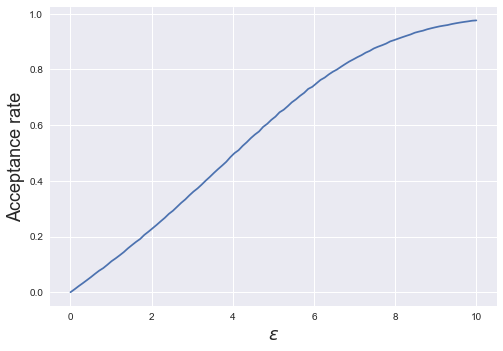

In [8]:
print(accepted_ratio)
plt.plot(epsilon_seq, accepted_ratio, '-')
plt.xlabel(r'$\epsilon$', fontsize=18)
plt.ylabel('Acceptance rate', fontsize=18)
plt.savefig('plots/TAR_curve_normal.pdf')
plt.show()


In [25]:
## TAR curve for g and k distribution
epsilon_seq = np.linspace(start=0, stop=5000, num = 50)
n = 5000
k = 5
counter = 0
accepted_ratio = []
output_list = []
#Run abc with these epsilon and get the ratio of accepted samples

for eps in epsilon_seq:
    print(float(counter/len(epsilon_seq))*100,"%")
    counter += 1
    aux = 0
    for rep in range(k):
        ABC_run = ABC(GKPriorSampler, GKLiklihoodSimulator, GKSummary, eps, data_gk , n)
        output_dict = {'eps': eps, 'accept ratio':sum(ABC_run.accept)/float(n)}
        output_list.append(output_dict)
        aux=aux+sum(ABC_run.accept)/n
    accepted_ratio.append(aux/k)
    
print("DONE :D")
    
pickle.dump(output_list, open( "data/acceptance_rate_gk.p", "wb" ) )

0.0 %
2.0 %
4.0 %
6.0 %
8.0 %
10.0 %
12.0 %
14.000000000000002 %
16.0 %
18.0 %
20.0 %
22.0 %
24.0 %
26.0 %
28.000000000000004 %
30.0 %
32.0 %
34.0 %
36.0 %
38.0 %
40.0 %
42.0 %
44.0 %
46.0 %
48.0 %
50.0 %
52.0 %
54.0 %
56.00000000000001 %
57.99999999999999 %
60.0 %
62.0 %
64.0 %
66.0 %
68.0 %
70.0 %
72.0 %
74.0 %
76.0 %
78.0 %
80.0 %
82.0 %
84.0 %
86.0 %
88.0 %
90.0 %
92.0 %
94.0 %
96.0 %
98.0 %
DONE :D


[0.0, 0.13012, 0.1696, 0.20116, 0.21911999999999998, 0.2326, 0.24703999999999998, 0.25876, 0.26344, 0.26932, 0.28208, 0.28300000000000003, 0.28724, 0.29348, 0.29684, 0.30463999999999997, 0.31008, 0.31056000000000006, 0.31132000000000004, 0.31799999999999995, 0.31851999999999997, 0.32632, 0.32868, 0.3224, 0.33499999999999996, 0.33643999999999996, 0.33668, 0.34147999999999995, 0.34847999999999996, 0.34352, 0.347, 0.34736, 0.35220000000000007, 0.35248, 0.35544, 0.35124, 0.35591999999999996, 0.35907999999999995, 0.36615999999999993, 0.36476, 0.3636400000000001, 0.36384, 0.36891999999999997, 0.36788, 0.3688, 0.3714, 0.38164, 0.36996, 0.37879999999999997, 0.38008]


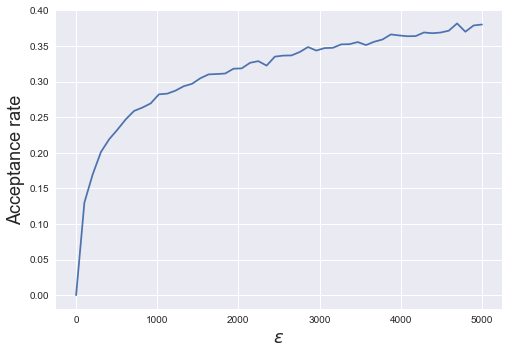

In [26]:
print(accepted_ratio)
plt.plot(epsilon_seq, accepted_ratio, '-')
plt.xlabel(r'$\epsilon$', fontsize=18)
plt.ylabel('Acceptance rate', fontsize=18)
plt.savefig('plots/TAR_curve_gk_distribution.pdf')
plt.show()